In [1]:
using MomentClosure, DiffEqJump, DiffEqBase, OrdinaryDiffEq, DiffEqBase.EnsembleAnalysis, Plots, Latexify

In [2]:
@parameters t, k_on, k_off, k_p, γ_p, b
@variables g(t), p(t)

# species
vars   = [g, p]

# parameters
ps = [k_on, k_off, k_p, γ_p, b]

# net stoichiometry matrix
# symbolic parameter in the matrix, `b`, denotes that the corresponding 
# reaction product is sampled from the geometric distribution with mean b
S_mat = [1 -1 0 0;
         0 0 b -1]

# propensity functions
as = [k_on*(1-g),    # G* -> G
      k_off*g*(p^2), # G + 2P -> G*
      k_p*g,         # G -> G + mP, m ~ Geometric(mean=b)
      γ_p*p]         # P -> ∅

binary_vars = [1]

rn = ReactionSystemMod(t, vars, ps, as, S_mat)

ReactionSystemMod(t, SymbolicUtils.Term{Real,Nothing}[g(t), p(t)], SymbolicUtils.Sym{ModelingToolkit.Parameter{Real},Nothing}[k_on, k_off, k_p, γ_p, b], SymbolicUtils.Mul{Real,Int64,Dict{Any,Number},Nothing}[k_on*(1 - g(t)), k_off*g(t)*(p(t)^2), k_p*g(t), γ_p*p(t)], Any[1 -1 0 0; 0 0 b -1])

In [3]:
# PARAMETER INITIALISATION
mean_p = 200
mean_b = 70
γ_p_val = 1
k_off_val = 0.001
k_on_val = 0.05

k_p_val = mean_p * γ_p_val * (k_off_val * mean_p^2 + k_on_val) / (k_on_val * mean_b)

pmap = [k_on => k_on_val,
        k_off => k_off_val,
        k_p => k_p_val,
        γ_p => γ_p_val,
        b => mean_b]

u₀ = [1, 1]

tspan = (0., 6.0)

(0.0, 6.0)

In [4]:
# create a discrete problem setting the simulation parameters
dprob = DiscreteProblem(u₀, tspan, pmap)

# create a JumpProblem compatible with ReactionSystemMod
jprob = JumpProblem(rn, dprob, Direct(), save_positions=(false, false))

# simulate 2×10⁴ SSA trajectories
ensembleprob  = EnsembleProblem(jprob)
@time sol_SSA = solve(ensembleprob, SSAStepper(), saveat=0.1, trajectories=20000)
# compute the means and variances
means_ssa, vars_ssa = timeseries_steps_meanvar(sol_SSA)

 23.200118 seconds (153.85 M allocations: 5.486 GiB, 31.19% gc time)


(t: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0]
u: [[1.0, 1.0], [4.9999999999999596e-5, 675.6861999999996], [0.0, 613.0833500000009], [0.0, 556.2300500000022], [0.00014999999999999996, 504.7747000000007], [0.00014999999999999955, 458.4439499999994], [0.0001999999999999996, 416.7528999999975], [9.999999999999948e-5, 379.360750000001], [4.999999999999964e-5, 344.96150000000017], [0.0002999999999999998, 313.92240000000095]  …  [0.00019999999999999868, 39.59709999999979], [0.0003000000000000014, 39.82390000000008], [0.00019999999999999912, 39.96915000000023], [0.0003500000000000004, 39.74794999999981], [0.00030000000000000003, 39.1334500000002], [9.999999999999967e-5, 38.91395000000017], [0.0001499999999999999, 38.458049999999965], [0.00024999999999999935, 37.63804999999998], [0.00019999999999999906, 37.37040000000004], [0.0002500000000000004, 36.73085000000016]], t: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  5.1, 5.2, 

In [5]:
eqs = generate_raw_moment_eqs(rn, 3)
latexify(eqs)

L"\begin{align*}
\frac{d\mu{_{10}}}{dt} =& k_{on} - k_{off} \mu{_{12}} - k_{on} \mu{_{10}} \\
\frac{d\mu{_{01}}}{dt} =& b k_{p} \mu{_{10}} - \gamma_{p} \mu{_{01}} \\
\frac{d\mu{_{20}}}{dt} =& k_{on} + k_{off} \mu{_{12}} + k_{on} \mu{_{10}} - 2 k_{off} \mu{_{22}} - 2 k_{on} \mu{_{20}} \\
\frac{d\mu{_{11}}}{dt} =& k_{on} \mu{_{01}} + b k_{p} \mu{_{20}} - k_{off} \mu{_{13}} - k_{on} \mu{_{11}} - \gamma_{p} \mu{_{11}} \\
\frac{d\mu{_{02}}}{dt} =& \gamma_{p} \mu{_{01}} + b k_{p} \mu{_{10}} + 2 b k_{p} \mu{_{11}} + 2 k_{p} \mu{_{10}} b^{2} - 2 \gamma_{p} \mu{_{02}} \\
\frac{d\mu{_{30}}}{dt} =& k_{on} + 3 k_{off} \mu{_{22}} + 2 k_{on} \mu{_{10}} - k_{off} \mu{_{12}} - 3 k_{off} \mu{_{32}} - 3 k_{on} \mu{_{30}} \\
\frac{d\mu{_{21}}}{dt} =& k_{off} \mu{_{13}} + k_{on} \mu{_{01}} + k_{on} \mu{_{11}} + b k_{p} \mu{_{30}} - 2 k_{off} \mu{_{23}} - 2 k_{on} \mu{_{21}} - \gamma_{p} \mu{_{21}} \\
\frac{d\mu{_{12}}}{dt} =& k_{on} \mu{_{02}} + \gamma_{p} \mu{_{11}} + b k_{p} \mu{_{20}} + 2 b k_{p} \mu{_

In [6]:
println(latexify(eqs))

\begin{align*}
\frac{d\mu{_{10}}}{dt} =& k_{on} - k_{off} \mu{_{12}} - k_{on} \mu{_{10}} \\
\frac{d\mu{_{01}}}{dt} =& b k_{p} \mu{_{10}} - \gamma_{p} \mu{_{01}} \\
\frac{d\mu{_{20}}}{dt} =& k_{on} + k_{off} \mu{_{12}} + k_{on} \mu{_{10}} - 2 k_{off} \mu{_{22}} - 2 k_{on} \mu{_{20}} \\
\frac{d\mu{_{11}}}{dt} =& k_{on} \mu{_{01}} + b k_{p} \mu{_{20}} - k_{off} \mu{_{13}} - k_{on} \mu{_{11}} - \gamma_{p} \mu{_{11}} \\
\frac{d\mu{_{02}}}{dt} =& \gamma_{p} \mu{_{01}} + b k_{p} \mu{_{10}} + 2 b k_{p} \mu{_{11}} + 2 k_{p} \mu{_{10}} b^{2} - 2 \gamma_{p} \mu{_{02}} \\
\frac{d\mu{_{30}}}{dt} =& k_{on} + 3 k_{off} \mu{_{22}} + 2 k_{on} \mu{_{10}} - k_{off} \mu{_{12}} - 3 k_{off} \mu{_{32}} - 3 k_{on} \mu{_{30}} \\
\frac{d\mu{_{21}}}{dt} =& k_{off} \mu{_{13}} + k_{on} \mu{_{01}} + k_{on} \mu{_{11}} + b k_{p} \mu{_{30}} - 2 k_{off} \mu{_{23}} - 2 k_{on} \mu{_{21}} - \gamma_{p} \mu{_{21}} \\
\frac{d\mu{_{12}}}{dt} =& k_{on} \mu{_{02}} + \gamma_{p} \mu{_{11}} + b k_{p} \mu{_{20}} + 2 b k_{p} \mu{_{2

In [7]:
# specify the indices of species which molecule numbers are binary
binary_vars = [1]
# simplify the moment equations using properties of Bernoulli variables
clean_eqs = bernoulli_moment_eqs(eqs, binary_vars)
latexify(clean_eqs)

L"\begin{align*}
\frac{d\mu{_{10}}}{dt} =& k_{on} - k_{off} \mu{_{12}} - k_{on} \mu{_{10}} \\
\frac{d\mu{_{01}}}{dt} =& b k_{p} \mu{_{10}} - \gamma_{p} \mu{_{01}} \\
\frac{d\mu{_{11}}}{dt} =& k_{on} \mu{_{01}} + b k_{p} \mu{_{10}} - k_{off} \mu{_{13}} - k_{on} \mu{_{11}} - \gamma_{p} \mu{_{11}} \\
\frac{d\mu{_{02}}}{dt} =& \gamma_{p} \mu{_{01}} + b k_{p} \mu{_{10}} + 2 b k_{p} \mu{_{11}} + 2 k_{p} \mu{_{10}} b^{2} - 2 \gamma_{p} \mu{_{02}} \\
\frac{d\mu{_{12}}}{dt} =& k_{on} \mu{_{02}} + \gamma_{p} \mu{_{11}} + b k_{p} \mu{_{10}} + 2 b k_{p} \mu{_{11}} + 2 k_{p} \mu{_{10}} b^{2} - k_{off} \mu{_{14}} - k_{on} \mu{_{12}} - 2 \gamma_{p} \mu{_{12}} \\
\frac{d\mu{_{03}}}{dt} =& b k_{p} \mu{_{10}} + 3 \gamma_{p} \mu{_{02}} + 3 b k_{p} \mu{_{11}} + 3 b k_{p} \mu{_{12}} + 6 k_{p} \mu{_{10}} b^{2} + 6 k_{p} \mu{_{10}} b^{3} + 6 k_{p} \mu{_{11}} b^{2} - \gamma_{p} \mu{_{01}} - 3 \gamma_{p} \mu{_{03}}
\end{align*}
"

In [8]:
println(latexify(clean_eqs))

\begin{align*}
\frac{d\mu{_{10}}}{dt} =& k_{on} - k_{off} \mu{_{12}} - k_{on} \mu{_{10}} \\
\frac{d\mu{_{01}}}{dt} =& b k_{p} \mu{_{10}} - \gamma_{p} \mu{_{01}} \\
\frac{d\mu{_{11}}}{dt} =& k_{on} \mu{_{01}} + b k_{p} \mu{_{10}} - k_{off} \mu{_{13}} - k_{on} \mu{_{11}} - \gamma_{p} \mu{_{11}} \\
\frac{d\mu{_{02}}}{dt} =& \gamma_{p} \mu{_{01}} + b k_{p} \mu{_{10}} + 2 b k_{p} \mu{_{11}} + 2 k_{p} \mu{_{10}} b^{2} - 2 \gamma_{p} \mu{_{02}} \\
\frac{d\mu{_{12}}}{dt} =& k_{on} \mu{_{02}} + \gamma_{p} \mu{_{11}} + b k_{p} \mu{_{10}} + 2 b k_{p} \mu{_{11}} + 2 k_{p} \mu{_{10}} b^{2} - k_{off} \mu{_{14}} - k_{on} \mu{_{12}} - 2 \gamma_{p} \mu{_{12}} \\
\frac{d\mu{_{03}}}{dt} =& b k_{p} \mu{_{10}} + 3 \gamma_{p} \mu{_{02}} + 3 b k_{p} \mu{_{11}} + 3 b k_{p} \mu{_{12}} + 6 k_{p} \mu{_{10}} b^{2} + 6 k_{p} \mu{_{10}} b^{3} + 6 k_{p} \mu{_{11}} b^{2} - \gamma_{p} \mu{_{01}} - 3 \gamma_{p} \mu{_{03}}
\end{align*}



In [9]:
normal_eqs = moment_closure(eqs, "normal", binary_vars)
latexify(normal_eqs, :closure)

L"\begin{align*}
\mu{_{13}} =& \mu{_{03}} \mu{_{10}} + 3 \mu{_{01}} \mu{_{12}} + 3 \mu{_{02}} \mu{_{11}} + 6 \mu{_{10}} \mu{_{01}}^{3} - 6 \mu{_{11}} \mu{_{01}}^{2} - 6 \mu{_{01}} \mu{_{02}} \mu{_{10}} \\
\mu{_{14}} =& \mu{_{04}} \mu{_{10}} + 4 \mu{_{01}} \mu{_{13}} + 6 \mu{_{02}} \mu{_{12}} + 4 \mu{_{03}} \mu{_{11}} + 24 \mu{_{11}} \mu{_{01}}^{3} + 36 \mu{_{02}} \mu{_{10}} \mu{_{01}}^{2} - 24 \mu{_{10}} \mu{_{01}}^{4} - 6 \mu{_{10}} \mu{_{02}}^{2} - 12 \mu{_{12}} \mu{_{01}}^{2} - 24 \mu{_{01}} \mu{_{02}} \mu{_{11}} - 8 \mu{_{01}} \mu{_{03}} \mu{_{10}}
\end{align*}
"

In [10]:
println(latexify(normal_eqs, :closure))

\begin{align*}
\mu{_{13}} =& \mu{_{03}} \mu{_{10}} + 3 \mu{_{01}} \mu{_{12}} + 3 \mu{_{02}} \mu{_{11}} + 6 \mu{_{10}} \mu{_{01}}^{3} - 6 \mu{_{11}} \mu{_{01}}^{2} - 6 \mu{_{01}} \mu{_{02}} \mu{_{10}} \\
\mu{_{14}} =& \mu{_{04}} \mu{_{10}} + 4 \mu{_{01}} \mu{_{13}} + 6 \mu{_{02}} \mu{_{12}} + 4 \mu{_{03}} \mu{_{11}} + 24 \mu{_{11}} \mu{_{01}}^{3} + 36 \mu{_{02}} \mu{_{10}} \mu{_{01}}^{2} - 24 \mu{_{10}} \mu{_{01}}^{4} - 6 \mu{_{10}} \mu{_{02}}^{2} - 12 \mu{_{12}} \mu{_{01}}^{2} - 24 \mu{_{01}} \mu{_{02}} \mu{_{11}} - 8 \mu{_{01}} \mu{_{03}} \mu{_{10}}
\end{align*}



In [11]:
dm_eqs = moment_closure(eqs, "derivative matching", binary_vars)
latexify(dm_eqs, :closure)

L"\begin{align*}
\mu{_{13}} =& \mu{_{03}} \mu{_{10}} \mu{_{01}}^{3} \mu{_{02}}^{-3} \mu{_{11}}^{-3} \mu{_{12}}^{3} \\
\mu{_{14}} =& \mu{_{04}} \mu{_{01}}^{-4} \mu{_{02}}^{6} \mu{_{03}}^{-4} \mu{_{10}}^{-1} \mu{_{11}}^{4} \mu{_{12}}^{-6} \mu{_{13}}^{4}
\end{align*}
"

In [12]:
println(latexify(dm_eqs, :closure))

\begin{align*}
\mu{_{13}} =& \mu{_{03}} \mu{_{10}} \mu{_{01}}^{3} \mu{_{02}}^{-3} \mu{_{11}}^{-3} \mu{_{12}}^{3} \\
\mu{_{14}} =& \mu{_{04}} \mu{_{01}}^{-4} \mu{_{02}}^{6} \mu{_{03}}^{-4} \mu{_{10}}^{-1} \mu{_{11}}^{4} \mu{_{12}}^{-6} \mu{_{13}}^{4}
\end{align*}



In [13]:
cond_gaussian_eqs = moment_closure(eqs, "conditional gaussian", binary_vars)
latexify(cond_gaussian_eqs, :closure)

L"\begin{align*}
\mu{_{13}} =& 3 \mu{_{11}} \mu{_{12}} \mu{_{10}}^{-1} - 2 \mu{_{10}}^{-2} \mu{_{11}}^{3} \\
\mu{_{14}} =& 3 \mu{_{10}}^{-1} \mu{_{12}}^{2} + 6 \mu{_{10}}^{-3} \mu{_{11}}^{4} + 4 \mu{_{11}} \mu{_{13}} \mu{_{10}}^{-1} - 12 \mu{_{12}} \mu{_{10}}^{-2} \mu{_{11}}^{2}
\end{align*}
"

In [14]:
println(latexify(cond_gaussian_eqs, :closure))

\begin{align*}
\mu{_{13}} =& 3 \mu{_{11}} \mu{_{12}} \mu{_{10}}^{-1} - 2 \mu{_{10}}^{-2} \mu{_{11}}^{3} \\
\mu{_{14}} =& 3 \mu{_{10}}^{-1} \mu{_{12}}^{2} + 6 \mu{_{10}}^{-3} \mu{_{11}}^{4} + 4 \mu{_{11}} \mu{_{13}} \mu{_{10}}^{-1} - 12 \mu{_{12}} \mu{_{10}}^{-2} \mu{_{11}}^{2}
\end{align*}



In [15]:
cond_dm_eqs = moment_closure(eqs, "conditional derivative matching", binary_vars)
latexify(cond_dm_eqs, :closure)

L"\begin{align*}
\mu{_{13}} =& \mu{_{10}} \mu{_{11}}^{-3} \mu{_{12}}^{3} \\
\mu{_{14}} =& \mu{_{10}}^{-1} \mu{_{11}}^{4} \mu{_{12}}^{-6} \mu{_{13}}^{4}
\end{align*}
"

In [16]:
println(latexify(dm_eqs, :closure))

\begin{align*}
\mu{_{13}} =& \mu{_{03}} \mu{_{10}} \mu{_{01}}^{3} \mu{_{02}}^{-3} \mu{_{11}}^{-3} \mu{_{12}}^{3} \\
\mu{_{14}} =& \mu{_{04}} \mu{_{01}}^{-4} \mu{_{02}}^{6} \mu{_{03}}^{-4} \mu{_{10}}^{-1} \mu{_{11}}^{4} \mu{_{12}}^{-6} \mu{_{13}}^{4}
\end{align*}



In [17]:
dm_eqs.odes.states

6-element Array{SymbolicUtils.Term{Real,Nothing},1}:
 μ₁₀(t)
 μ₀₁(t)
 μ₁₁(t)
 μ₀₂(t)
 μ₁₂(t)
 μ₀₃(t)

In [18]:
plt_m = plot()   # plot mean protein number
plt_std = plot() # plot ssd of protein number

# construct the initial molecule number mapping
u₀map = deterministic_IC(u₀, dm_eqs)

# solve moment ODEs for each closure and plot the results
for closure in ["normal", "derivative matching", 
                "conditional gaussian", "conditional derivative matching"]
    
    # it is very quick so we just apply all closures again
    closed_eqs = moment_closure(eqs, closure, binary_vars)
    
    # solve the system of moment ODEs
    oprob = ODEProblem(closed_eqs, u₀map, tspan, pmap)
    sol = solve(oprob, AutoTsit5(Rosenbrock23()), saveat=0.01)
    
    # μ₀₁ is 2nd and μ₀₂ is 4th element in sol
    plt_m = plot!(plt_m, sol, vars=(0, 2), label=closure)
    plt_std = plot!(plt_std, sol.t, sqrt.(sol[4, :] .- sol[2, :].^2), label=closure)
    
end

plt_m = plot!(plt_m, xlabel="Time [hr]", ylabel="Protein mean level")
plt_m = plot!(plt_m, means_ssa.t, means_ssa[2,:], label="SSA", linestyle=:dash, color="gray")
plt_std = plot!(plt_std, xlabel="Time [hr]", ylabel="Protein standard deviation")
plt_std = plot!(plt_std, vars_ssa.t, sqrt.(vars_ssa[2,:]), label="SSA", linestyle=:dash, color="gray");

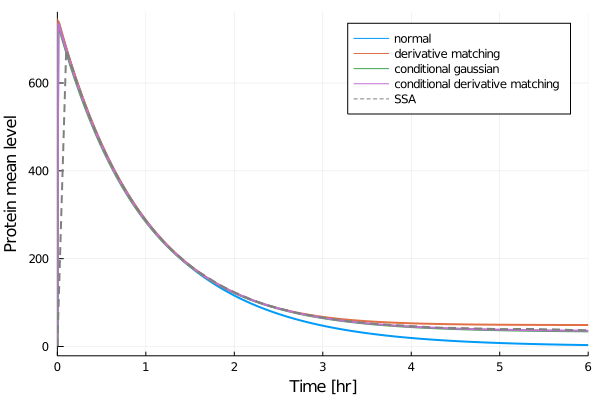

In [19]:
plot(plt_m, lw=2)

In [20]:
savefig("../docs/src/assets/gene_1_means.svg")

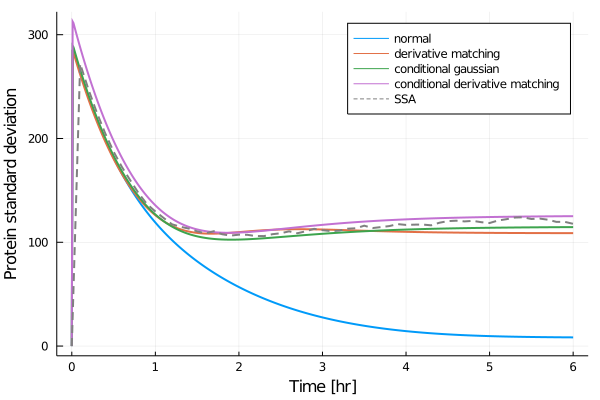

In [21]:
plot(plt_std, lw=2)

In [22]:
savefig("../docs/src/assets/gene_1_stds.svg")

In [23]:
@parameters t, kx_on, kx_off, ky_on, ky_off, γ_x, γ_y, k_x, k_y, b_x, b_y
@variables x(t), y(t), g_x(t), g_y(t)

# g_x - gene state of X protein producing gene
# g_y - gene state of Y protein producing gene
# x, y - proteins X and Y
vars = [g_x, g_y, x, y]

# both g_x and g_y are Bernoulli random variables
binary_vars = [1, 2]

ps = [kx_on, kx_off, ky_on, ky_off, γ_x, γ_y, k_x, k_y, b_x, b_y]

# b_x and b_y denote the mean burst sizes for gene production in geometrically-distributed bursts
S = [1 -1  0  0  0    0  0    0; 
     0  0  1 -1  0    0  0    0;
     0  0  0  0  b_x -1  0    0;
     0  0  0  0  0    0  b_y -1]

as = [kx_on*(1-g_x)*y,    # 0   -> g_x
      kx_off*g_x,         # g_x -> 0
      ky_on*(1-g_y),      # 0   -> g_y
      ky_off*g_y*x,       # g_y -> 0
      k_x*g_x,            # 0   -> mx, m ~ Geometric(mean=b_x)     
      γ_x*x,              # x   -> 0
      k_y*g_y,            # 0   -> ly, l ~ Geometric(mean=b_y)
      γ_y*y]              # y   -> 0

rn = ReactionSystemMod(t, vars, ps, as, S)

# Parameter initialisation

mean_x = 100
mean_y = 100
mean_b_x = 5
mean_b_y = 5
γ_x_val = 1
γ_y_val = 1
kx_off_val = 4
ky_on_val = 0.3
kx_on_val = 0.05
ky_off_val = 0.05

k_x_val = mean_x * γ_x_val * (kx_off_val * mean_y^2 + kx_on_val) / (kx_on_val * mean_b_x)
k_y_val = mean_y * γ_y_val * (ky_off_val * mean_x^2 + ky_on_val) / (ky_on_val * mean_b_y)

# unclear if Soltani et al. (2015) actually used this parameter set as X numbers jump to millions
# making SSA extremely slow...

# introduce additional rescaling (otherwise rate coefficients are too high)
k_x_val *= 0.00003
k_y_val *= 0.01

# parameter mapping
pmap = [kx_on => kx_on_val,
        kx_off => kx_off_val,
        ky_on => ky_on_val,
        ky_off => ky_off_val,
        k_x => k_x_val,
        k_y => k_y_val,
        γ_x => γ_x_val,
        γ_y => γ_y_val,
        b_x => mean_b_x,
        b_y => mean_b_y]

# initial gene state and protein number, order [g_x, g_y, x, y]
u₀ = [1, 1, 1, 1]

# time interval to solve on
tspan = (0., 12.0);

In [24]:
eqs = generate_raw_moment_eqs(rn, 4);

In [25]:
# can compare to results in Soltani et al. (2015)
closed_eqs = moment_closure(eqs, "derivative matching", binary_vars)
latexify(closed_eqs, :closure)

L"\begin{align*}
\mu{_{1130}} =& \mu{_{0130}} \mu{_{1030}} \mu{_{1100}} \mu{_{0010}}^{-3} \mu{_{0020}}^{3} \mu{_{0030}}^{-1} \mu{_{0100}}^{-1} \mu{_{0110}}^{3} \mu{_{0120}}^{-3} \mu{_{1000}}^{-1} \mu{_{1010}}^{3} \mu{_{1020}}^{-3} \mu{_{1110}}^{-3} \mu{_{1120}}^{3} \\
\mu{_{0140}} =& \mu{_{0040}} \mu{_{0010}}^{-4} \mu{_{0020}}^{6} \mu{_{0030}}^{-4} \mu{_{0100}}^{-1} \mu{_{0110}}^{4} \mu{_{0120}}^{-6} \mu{_{0130}}^{4} \\
\mu{_{1121}} =& \mu{_{0020}} \mu{_{0101}} \mu{_{0121}} \mu{_{1001}} \mu{_{1021}} \mu{_{1100}} \mu{_{1120}} \mu{_{0001}}^{-1} \mu{_{0010}}^{-2} \mu{_{0011}}^{2} \mu{_{0021}}^{-1} \mu{_{0100}}^{-1} \mu{_{0110}}^{2} \mu{_{0111}}^{-2} \mu{_{0120}}^{-1} \mu{_{1000}}^{-1} \mu{_{1010}}^{2} \mu{_{1011}}^{-2} \mu{_{1020}}^{-1} \mu{_{1101}}^{-1} \mu{_{1110}}^{-2} \mu{_{1111}}^{2} \\
\mu{_{1031}} =& \mu{_{0031}} \mu{_{1001}} \mu{_{1030}} \mu{_{0001}}^{-1} \mu{_{0010}}^{-3} \mu{_{0011}}^{3} \mu{_{0020}}^{3} \mu{_{0021}}^{-3} \mu{_{0030}}^{-1} \mu{_{1000}}^{-1} \mu{_{1010}}^{3} \mu{

In [26]:
closed_eqs = moment_closure(eqs, "normal", binary_vars)
latexify(closed_eqs, :closure); # very long

In [27]:
closed_eqs = moment_closure(eqs, "conditional gaussian", binary_vars)
latexify(closed_eqs, :closure)

L"\begin{align*}
\mu{_{1130}} =& 3 \mu{_{1110}} \mu{_{1120}} \mu{_{1100}}^{-1} - 2 \mu{_{1100}}^{-2} \mu{_{1110}}^{3} \\
\mu{_{0140}} =& 3 \mu{_{0100}}^{-1} \mu{_{0120}}^{2} + 6 \mu{_{0100}}^{-3} \mu{_{0110}}^{4} + 4 \mu{_{0110}} \mu{_{0130}} \mu{_{0100}}^{-1} - 12 \mu{_{0120}} \mu{_{0100}}^{-2} \mu{_{0110}}^{2} \\
\mu{_{1121}} =& \mu{_{1101}} \mu{_{1120}} \mu{_{1100}}^{-1} + 2 \mu{_{1110}} \mu{_{1111}} \mu{_{1100}}^{-1} - 2 \mu{_{1101}} \mu{_{1100}}^{-2} \mu{_{1110}}^{2} \\
\mu{_{1031}} =& \mu{_{1001}} \mu{_{1030}} \mu{_{1000}}^{-1} + 6 \mu{_{1001}} \mu{_{1000}}^{-3} \mu{_{1010}}^{3} + 3 \mu{_{1010}} \mu{_{1021}} \mu{_{1000}}^{-1} + 3 \mu{_{1011}} \mu{_{1020}} \mu{_{1000}}^{-1} - 6 \mu{_{1011}} \mu{_{1000}}^{-2} \mu{_{1010}}^{2} - 6 \mu{_{1001}} \mu{_{1010}} \mu{_{1020}} \mu{_{1000}}^{-2} \\
\mu{_{0131}} =& \mu{_{0101}} \mu{_{0130}} \mu{_{0100}}^{-1} + 6 \mu{_{0101}} \mu{_{0100}}^{-3} \mu{_{0110}}^{3} + 3 \mu{_{0110}} \mu{_{0121}} \mu{_{0100}}^{-1} + 3 \mu{_{0111}} \mu{_{0120}} \mu{_{

In [28]:
closed_eqs = moment_closure(eqs, "conditional derivative matching", binary_vars)
latexify(closed_eqs, :closure)

L"\begin{align*}
\mu{_{1130}} =& \mu{_{1100}} \mu{_{1110}}^{-3} \mu{_{1120}}^{3} \\
\mu{_{0140}} =& \mu{_{0100}}^{-1} \mu{_{0110}}^{4} \mu{_{0120}}^{-6} \mu{_{0130}}^{4} \\
\mu{_{1121}} =& \mu{_{1100}} \mu{_{1120}} \mu{_{1101}}^{-1} \mu{_{1110}}^{-2} \mu{_{1111}}^{2} \\
\mu{_{1031}} =& \mu{_{1001}} \mu{_{1030}} \mu{_{1000}}^{-1} \mu{_{1010}}^{3} \mu{_{1011}}^{-3} \mu{_{1020}}^{-3} \mu{_{1021}}^{3} \\
\mu{_{0131}} =& \mu{_{0101}} \mu{_{0130}} \mu{_{0100}}^{-1} \mu{_{0110}}^{3} \mu{_{0111}}^{-3} \mu{_{0120}}^{-3} \mu{_{0121}}^{3} \\
\mu{_{1112}} =& \mu{_{1100}} \mu{_{1102}} \mu{_{1101}}^{-2} \mu{_{1110}}^{-1} \mu{_{1111}}^{2} \\
\mu{_{1022}} =& \mu{_{1000}}^{-1} \mu{_{1001}}^{2} \mu{_{1002}}^{-1} \mu{_{1010}}^{2} \mu{_{1011}}^{-4} \mu{_{1012}}^{2} \mu{_{1020}}^{-1} \mu{_{1021}}^{2} \\
\mu{_{0122}} =& \mu{_{0100}}^{-1} \mu{_{0101}}^{2} \mu{_{0102}}^{-1} \mu{_{0110}}^{2} \mu{_{0111}}^{-4} \mu{_{0112}}^{2} \mu{_{0120}}^{-1} \mu{_{0121}}^{2} \\
\mu{_{1103}} =& \mu{_{1100}} \mu{_{1101}}^{-3} 

In [29]:
closed_eqs.odes.states

40-element Array{SymbolicUtils.Term{Real,Nothing},1}:
 μ₁₀₀₀(t)
 μ₀₁₀₀(t)
 μ₀₀₁₀(t)
 μ₀₀₀₁(t)
 μ₁₁₀₀(t)
 μ₁₀₁₀(t)
 μ₀₁₁₀(t)
 μ₀₀₂₀(t)
 μ₁₀₀₁(t)
 μ₀₁₀₁(t)
 μ₀₀₁₁(t)
 μ₀₀₀₂(t)
 μ₁₁₁₀(t)
 ⋮
 μ₁₁₁₁(t)
 μ₁₀₂₁(t)
 μ₀₁₂₁(t)
 μ₀₀₃₁(t)
 μ₁₁₀₂(t)
 μ₁₀₁₂(t)
 μ₀₁₁₂(t)
 μ₀₀₂₂(t)
 μ₁₀₀₃(t)
 μ₀₁₀₃(t)
 μ₀₀₁₃(t)
 μ₀₀₀₄(t)

In [30]:
using Sundials # for CVODE_BDF

closed_eqs = moment_closure(eqs, "normal", binary_vars)
u₀map = deterministic_IC(u₀, closed_eqs)

oprob = ODEProblem(closed_eqs, u₀map, tspan, pmap)
sol = solve(oprob, CVODE_BDF(), saveat=0.1);


[CVODES WARNING]  CVode
  Internal t = 3.56363 and h = 9.79674e-017 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 3.56363 and h = 9.79674e-017 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 3.56363 and h = 1.87067e-016 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 3.56363 and h = 2.05954e-016 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 3.56363 and h = 2.05954e-016 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 3.56363 and h = 2.05954e-016 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 3.56363 and h = 4.54763e-017 are such that t + h = t on the next step. The solver will con

In [31]:
closed_eqs = moment_closure(eqs, "conditional gaussian", binary_vars)
u₀map = deterministic_IC(u₀, closed_eqs)

oprob = ODEProblem(closed_eqs, u₀map, tspan, pmap)
sol = solve(oprob, CVODE_BDF(), saveat=0.1);


[CVODES WARNING]  CVode
  Internal t = 0.775249 and h = 4.75035e-017 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.775249 and h = 4.75035e-017 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.775249 and h = 2.62465e-017 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.775249 and h = 1.8027e-017 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.775249 and h = 1.31078e-017 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.775249 and h = 1.31078e-017 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.775249 and h = 7.2355e-018 are such that t + h = t on the next step. The solver wil

In [32]:
plot(sol, vars=(0, 4))
plot!(means_ssa.t, means_ssa[4,:])

LoadError: [91mBoundsError: attempt to access 2-element Array{Float64,1} at index [4][39m

In [33]:
plot(sol.t, sqrt.(sol[12, :] .- sol[4, :].^2), xlims=(0., 12.))
plot!(sol.t, sqrt.(vars_ssa[4,:]))

LoadError: [91mDomainError with -5.9689997579478584e10:[39m
[91msqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).[39m

In [34]:
dprob = DiscreteProblem(u₀, tspan, pmap)
jprob = JumpProblem(rn, dprob, Direct(), save_positions=(false, false))

ensembleprob  = EnsembleProblem(jprob)
@time sol_SSA = solve(ensembleprob, SSAStepper(), saveat=0.1, trajectories=20000)
means_ssa, vars_ssa = timeseries_steps_meanvar(sol_SSA);

959.286216 seconds (3.43 G allocations: 107.662 GiB, 64.66% gc time)


In [35]:
plt_m = plot()   # plot mean activator protein number
plt_std = plot() # plot ssd of activator protein number

for closure in ["derivative matching", "conditional derivative matching"]

    closed_eqs = moment_closure(eqs, closure, binary_vars)

    u₀map = deterministic_IC(u₀, closed_eqs)
    oprob = ODEProblem(closed_eqs, u₀map, tspan, pmap)
    sol = solve(oprob, Tsit5(), saveat=0.1)

    # μ₀₀₀₁ is the 4th and μ₀₀₀₂ is the 12th element in sol (can check with closed_eqs.odes.states)
    plt_m = plot!(plt_m, sol, vars=(0, 4), label=closure)
    plt_std = plot!(plt_std, sol.t, sqrt.(sol[12, :] .- sol[4, :].^2), label=closure)
end

plt_m = plot!(plt_m, xlabel="Time [hr]", ylabel="Activator mean level")
plt_m = plot!(plt_m, means_ssa.t, means_ssa[4,:], label="SSA", linestyle=:dash, color="gray")
plt_std = plot!(plt_std, xlabel="Time [hr]", ylabel="Activator standard deviation")
plt_std = plot!(plt_std, vars_ssa.t, sqrt.(vars_ssa[4,:]), label="SSA", linestyle=:dash, color="gray");

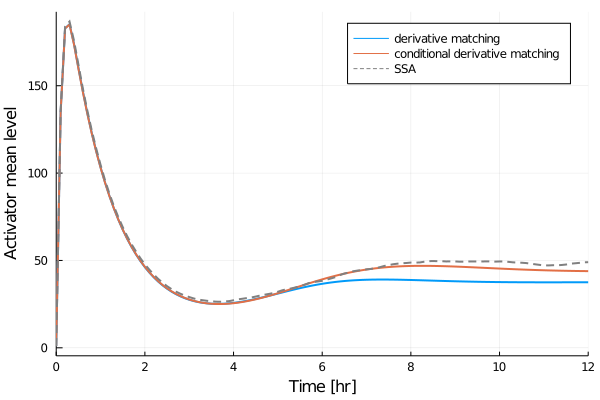

In [55]:
plot(plt_m, lw=2)

In [56]:
savefig("../docs/src/assets/gene_2_means.svg")

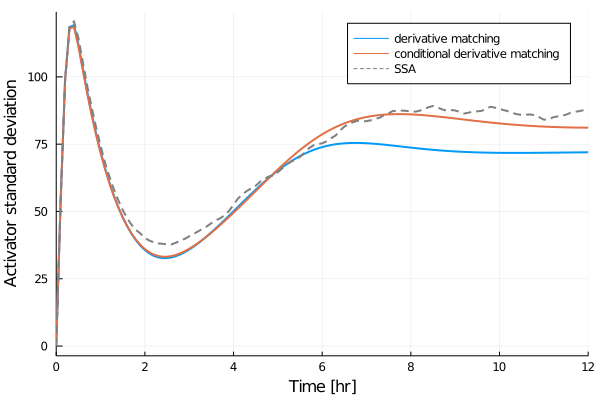

In [57]:
plot(plt_std, lw=2, xlims=(0., 12.))

In [58]:
savefig("../docs/src/assets/gene_2_stds.svg")